In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import cv2
tf.__version__

'2.4.1'

In [38]:
# from keras import backend
# backend.set_image_data_format('channels_first')
# print(backend.image_data_format())

In [2]:
json_file = open('/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.388.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: onnx2keras.utils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: onnx2keras.elementwise_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [3]:
# model = keras.models.load_model('/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.388.h5')
model.load_weights("/content/drive/My Drive/basil_leaves/model_weights/onnx_apex&grad_dexined__parameter_red_epoch35_dc_0.388.h5")
print("Loaded model from disk")
# output = model.predict_on_batch(np.expand_dims(image, axis=0))

Loaded model from disk


In [31]:
id ='/content/drive/MyDrive/basil_leaves/images-1/2008RR000131AB-2020-12-05T06-11-06.jpg'
def transform_single(id):
  all_img=[]
  img = cv2.imread(id)
  showimg = img.copy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (2560,1792))
  for i in range(10):    # 10
    for j in range(7):  # 7                                       ## due to large resolution images each image is sub-divided into an image of 500,500 dim
      row,col = 256,256
      img_c = img[j*row:(j+1)*row,i*col:(i+1)*col] #[j*243:(j+1)*243,i*324:(i+1)*324]#[j*486:(j+1)*486,i*648:(i+1)*648]     ## than resized to (270,270) and finally included in a list if its mask contains  
      img_c = img_c.transpose(2,0,1)
      img_norm = img_c/255
      p_img = img_norm.astype(np.float32) #FloatTensor
      all_img.append(p_img)

  fimg = []
  for i in range(len(all_img)):
    bimg = np.expand_dims(all_img[i], axis=0)
    fimg.append(bimg)
  # fimg[0].shape
  fimg = np.vstack(fimg)

  mask = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
  emp_mask = np.zeros(mask.shape, dtype=np.float32)
  return showimg, emp_mask, fimg
# len(all_img)


In [33]:
showimg, emp_mask, fimg = transform_single(id)
output = model.predict_on_batch(fimg)
out = output[-1]
# out[0].shape

In [36]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def predict(out, emp_mask):
  out = sigmoid(out)
  t=0
  for i in range(10):    # 10
      for j in range(7):  # 7                                       
        row,col = 256,256
        img = out[t].transpose(1,2,0).squeeze()
        emp_mask[j*row:(j+1)*row,i*col:(i+1)*col] = cv2.bitwise_or(img, emp_mask[j*row:(j+1)*row,i*col:(i+1)*col], mask = None)
        t=t+1
  emp_mask = cv2.resize(emp_mask, (2592,1944))
  return emp_mask

pred_mask = predict(out, emp_mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


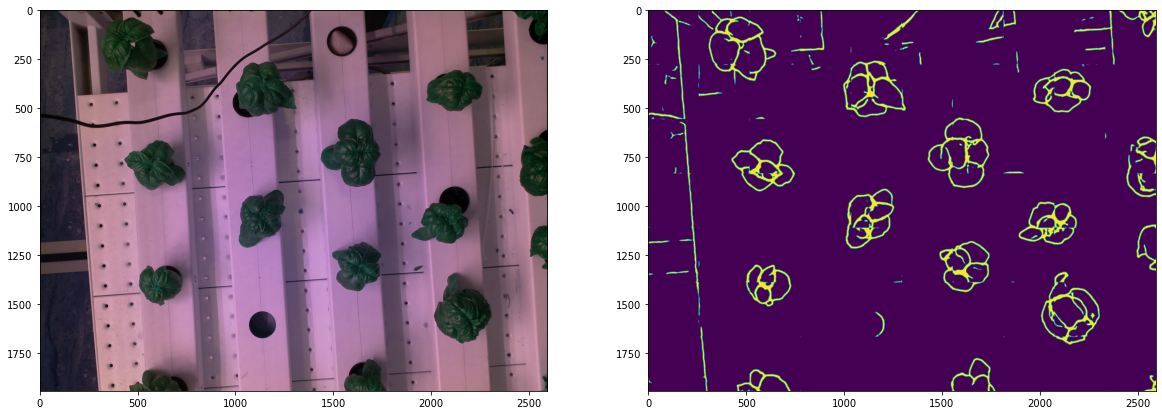

In [37]:
plt.figure(figsize = (20,20))
plt.subplot(221), plt.imshow(showimg)
plt.subplot(222), plt.imshow(pred_mask)
plt.show()